# Stain-free leukocyte prediction

## Package imports

In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
# %load ../common_.py
import sys
sys.path.append("../../..")
from workflow.common import *

In [5]:
import fcsparser
from scip_workflows import core
import flowutils
import shap
shap.initjs()

In [6]:
import sklearn.base
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, scale, minmax_scale, LabelEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

In [7]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.pipeline import make_pipeline as imb_make_pipeline

In [8]:
from multiprocessing import Pool
from scipy.stats import spearmanr
import pickle
import hiplot

In [9]:
plt.rcParams['figure.dpi'] = 200

## Data import

Feature values from SCIP and IDEAS are imported. In total we import 133354 features.

In [12]:
data_dir = Path(os.environ["HOME"]) / "scratch/data/vsc/datasets/wbc/scip/20220713131400/"

In [ ]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/wbc/scip/20220713131400/"

In [15]:
df_scip = pq.read_table(data_dir / "features.parquet").to_pandas()

# cat_type = CategoricalDtype(
#     categories=sorted(df_scip["meta_group"].astype(int).unique()), ordered=True)
# df_scip["meta_group"] = df_scip["meta_group"].astype(int).astype(cat_type)

# cat_type = CategoricalDtype(
#     categories=sorted(df_scip["meta_part"].astype(int).unique()), ordered=True)
# df_scip["meta_part"] = df_scip["meta_part"].astype(int).astype(cat_type)

# df_scip = df_scip.set_index(["meta_group", "meta_part", "meta_fix", "meta_object_number"])

df_scip = df_scip[numpy.load(
    data_dir / "indices/columns.npy", allow_pickle=True)]
df_scip = df_scip.loc[numpy.load(
    data_dir / "indices/index.npy", allow_pickle=True)]

labels = pq.read_table(data_dir / "labels.parquet").to_pandas()
df_scip = df_scip.merge(labels, left_index=True, right_index=True)
# df_scip["meta_label"] = pandas.Categorical(df_scip["meta_label"], ordered=True)

df_scip.shape

(218404, 3923)

In [16]:
df_scip["meta_label"].value_counts()

CD15 + Neutrophils    132536
CD4 T cells            32183
CD8 T cell             13899
unknown                13248
CD19 pos B cells        8408
CD56+ NK Cells          6207
NK T cells              4231
CD14+ Monocyte          4041
Eosinophils             3651
Name: meta_label, dtype: int64

In [17]:
df = df_scip

In [18]:
df.shape

(218404, 3923)

## Continue with events assigned to cell states

I filter out the events falling between manual gates. This is only a small amount of events

In [19]:
df = df.loc[df["meta_label"] != "unknown"].copy()
df.shape

(205156, 3923)

In [20]:
df["meta_label"] = df["meta_label"].astype("category")

In [21]:
enc = LabelEncoder().fit(df["meta_label"])

## Classification and feature analysis using an Extreme Gradient Boosting classifier

### Tuning hyper parameters

We inspect the results from recursive successive halving hyper parameter optimization

In [22]:
def rsh_plot(grid):
    results = pandas.DataFrame(grid.cv_results_)
    results["params_str"] = results.params.apply(lambda foo: str({k:v for k,v in foo.items() if k != "xgbclassifier__n_estimators"}))
    
    results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
    mean_scores = results.pivot(
        index="iter", columns="params_str", values="mean_test_score"
    )
    
    fig, ax = plt.subplots(dpi=150)
    
    twin_res = ax.twinx()
    twin_cand = ax.twinx()
    twin_cand.spines.right.set_position(("axes", 1.2))
    
    p1, = twin_res.plot(
        numpy.arange(grid.n_iterations_), 
        [grid.n_resources_[i] for i in range(grid.n_iterations_)], 
        "--", alpha=0.7, linewidth=1, color="#E09F3E", zorder=-1)
    p2, = twin_cand.plot(
        numpy.arange(grid.n_iterations_), 
        [grid.n_candidates_[i] for i in range(grid.n_iterations_)], 
        "--", alpha=0.7, linewidth=1, color="#004E98", zorder=-2)
    
    mean_scores.plot(legend=False, alpha=0.6, ax=ax, color="#E15554", zorder=2)
    
    twin_res.yaxis.label.set_color(p1.get_color())
    twin_cand.yaxis.label.set_color(p2.get_color())

    ax.set_xticks(range(grid.n_iterations_))
    ax.set_title("Scores of candidates over iterations")
    ax.set_ylabel("balanced accuracy", fontsize=10)
    ax.set_xlabel("iterations", fontsize=10)
    twin_res.set_ylabel("Number of resources")
    twin_cand.set_ylabel("Number of candidates")
    twin_res.tick_params(axis='y', colors=p1.get_color())
    twin_cand.tick_params(axis='y', colors=p2.get_color())
    
    seaborn.despine(fig, right=False, trim=True)
    
def hip_plot(grid):
    df = pandas.DataFrame(grid.cv_results_["params"])
    df["mean_test_balanced_accuracy"] = grid.cv_results_["mean_test_score"]
    df["mean_train_balanced_accuracy"] = grid.cv_results_["mean_train_score"]
    df["std_test_balanced_accuracy"] = grid.cv_results_["std_test_score"]
    df["std_train_balanced_accuracy"] = grid.cv_results_["std_train_score"]

    hiplot.Experiment.from_iterable(df.to_dict(orient="records")).display()

In [55]:
with open(data_dir / f"hpo/rsh_full.pickle", "rb") as fh:
    grid_full = pickle.load(fh)

In [56]:
grid_full["test_balanced_accuracy"].mean(), scipy.stats.sem(grid_full["test_balanced_accuracy"])

(0.7691934707721455, 0.004302335376836568)

In [57]:
grid_full["test_balanced_accuracy"], grid_full["train_balanced_accuracy"]

(array([0.75838555, 0.76129523, 0.76842004, 0.77834882, 0.77951771]),
 array([0.80508451, 0.83211546, 0.82925101, 0.86815152, 0.86871643]))

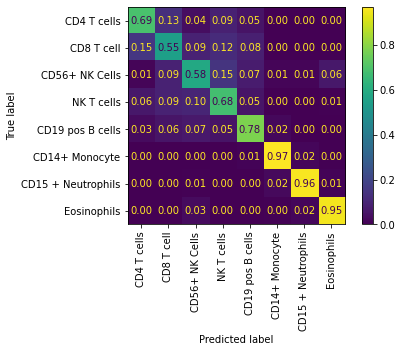

In [58]:
X = df.filter(regex="(BF1|BF2|SSC)$")
y = enc.transform(df["meta_label"])
preds = []
true = []

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for estimator, (_, test_index) in zip(grid_full["estimator"], skf.split(X, y)):
    X_test, y_test = X.iloc[test_index], y[test_index]
    preds.extend(estimator.predict(X_test))    
    true.extend(y_test)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    true, preds, 
    labels=[3, 5, 4, 7, 2, 0, 1, 6],
    display_labels=enc.classes_[[3, 5, 4, 7, 2, 0, 1, 6]],
    normalize='true', xticks_rotation="vertical", values_format=".2f",
    ax=ax
)
plt.savefig(data_dir / "figures" / "xgb_wbc_cv_confmat.png", bbox_inches="tight")

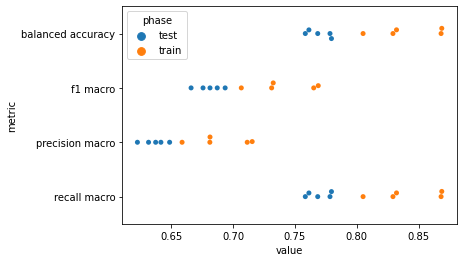

In [60]:
grid_full_df = pandas.DataFrame(grid_full).drop(columns=["score_time", "fit_time", "estimator"]).melt()
grid_full_df["phase"] = grid_full_df["variable"].apply(lambda r: r.split("_")[0])
grid_full_df["metric"] = grid_full_df["variable"].apply(lambda r: " ".join(r.split("_")[1:]))

seaborn.swarmplot(data=grid_full_df, x='value', y='metric', hue='phase')

plt.savefig(data_dir / "figures" / "xgb_wbc_cv_scores.png", bbox_inches="tight")

In [65]:
scores_df = grid_full_df.groupby(["metric", "phase"])["value"].agg(['mean', scipy.stats.sem])
scores_df.index.names = ["Metric", "Phase"]
scores_df["Mean (std. error)"] = scores_df.apply(lambda r: "%.3f (%.3f)" % (r["mean"], r["sem"]), axis=1)
scores_df = scores_df.reset_index().pivot(index="Metric", values="Mean (std. error)", columns="Phase")
scores_df.index.name = ""

print(scores_df.style.to_latex(hrules=True))

\begin{tabular}{lll}
\toprule
Phase & test & train \\
 &  &  \\
\midrule
balanced accuracy & 0.769 (0.004) & 0.841 (0.012) \\
f1 macro & 0.681 (0.005) & 0.741 (0.012) \\
precision macro & 0.636 (0.004) & 0.690 (0.011) \\
recall macro & 0.769 (0.004) & 0.841 (0.012) \\
\bottomrule
\end{tabular}



In [32]:
with open(data_dir / f"hpo/rsh_cyto_overfit.pickle", "rb") as fh:
    grid_cyto = pickle.load(fh)

In [33]:
grid_cyto["test_balanced_accuracy"].mean(), scipy.stats.sem(grid_cyto["test_balanced_accuracy"])

(0.8272259869383227, 0.002370453476150684)

In [34]:
grid_cyto["test_balanced_accuracy"], grid_cyto["train_balanced_accuracy"]

(array([0.81982083, 0.83174006, 0.82342481, 0.83097569, 0.83016854]),
 array([0.91079562, 0.9348605 , 0.94100039, 0.89823381, 0.9499213 ]))

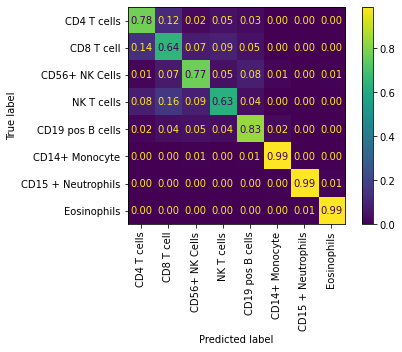

In [35]:
X = df.drop('late', level="meta_fix").drop(0, level="meta_group").filter(regex="(BF1|BF2|SSC)$")#.fillna(0)
y = enc.transform(df.drop('late', level="meta_fix").drop(0, level="meta_group")["meta_label"])
preds = []
true = []

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for estimator, (_, test_index) in zip(grid_cyto["estimator"], skf.split(X, y)):
    X_test, y_test = X.iloc[test_index], y[test_index]
    preds.extend(estimator.predict(X_test))    
    true.extend(y_test)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    true, preds, 
    labels=[3, 5, 4, 7, 2, 0, 1, 6],
    display_labels=enc.classes_[[3, 5, 4, 7, 2, 0, 1, 6]],
    normalize='true', xticks_rotation="vertical", values_format=".2f",
    ax=ax
)
plt.savefig(data_dir / "figures" / "xgb_wbc_cyto_cv_confmat.png", bbox_inches="tight")

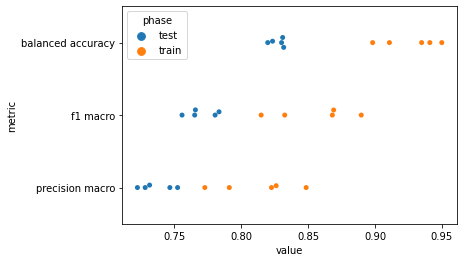

In [52]:
grid_cyto_df = pandas.DataFrame(grid_cyto).drop(columns=["score_time", "fit_time", "estimator", "train_recall_macro", "test_recall_macro"]).melt()
grid_cyto_df["phase"] = grid_cyto_df["variable"].apply(lambda r: r.split("_")[0])
grid_cyto_df["metric"] = grid_cyto_df["variable"].apply(lambda r: " ".join(r.split("_")[1:]))

seaborn.swarmplot(data=grid_cyto_df, x='value', y='metric', hue='phase')

plt.savefig(data_dir / "figures" / "xgb_wbc_cyto_cv_scores.png", bbox_inches="tight")

In [48]:
scores_df = grid_cyto_df.groupby(["metric", "phase"])["value"].agg(['mean', scipy.stats.sem])
scores_df.index.names = ["Metric", "Phase"]
scores_df["Mean (std. error)"] = scores_df.apply(lambda r: "%.3f (%.3f)" % (r["mean"], r["sem"]), axis=1)
print(scores_df.reset_index().pivot(index="Metric", values="Mean (std. error)", columns="Phase").style.to_latex(hrules=True))

\begin{tabular}{lll}
\toprule
Phase & test & train \\
Metric &  &  \\
\midrule
balanced accuracy & 0.827 (0.002) & 0.927 (0.010) \\
f1 macro & 0.770 (0.005) & 0.855 (0.014) \\
precision macro & 0.736 (0.006) & 0.812 (0.013) \\
recall macro & 0.827 (0.002) & 0.927 (0.010) \\
\bottomrule
\end{tabular}



In [50]:
scores_df.reset_index().pivot(index="Metric", values="Mean (std. error)", columns="Phase").to_parquet(data_dir / "scores.parquet")

In [54]:
grid_cyto_df.to_parquet(data_dir / "scores.parquet")

### Interpreting the Extreme Gradient Boosting classifier

#### Feature importances of the decision trees

In [99]:
model = model_xgb_s.named_steps["xgbclassifier"]

In [100]:
s = numpy.argsort(model.feature_importances_)
pandas.DataFrame(dict(feature = Xs.columns[s[-10:][::-1]], importance=model.feature_importances_[s[-10:][::-1]]))

,feature,importance
0,scip_feat_bgcorr_edge_mad_SSC,0.083615
1,scip_feat_edge_mad_SSC,0.054030
2,scip_feat_moments_central-2-2_BF2,0.049699
3,scip_feat_bgcorr_edge_median_SSC,0.024519
4,scip_feat_edge_sum_SSC,0.019041
5,scip_feat_bgcorr_edge_upper_quartile_SSC,0.017917
6,scip_feat_sobel_std_SSC,0.017707
7,scip_feat_feret_diameter_max_BF2,0.016155
8,scip_feat_combined_upper_quartile_SSC,0.015639
9,scip_feat_combined_bgcorr_edge_sum_BF1,0.014957


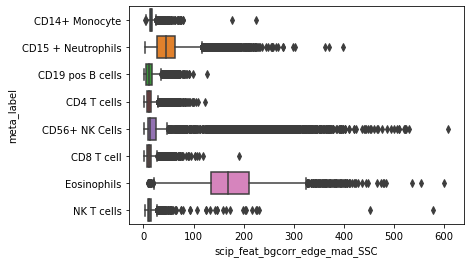

In [102]:
seaborn.boxplot(
    data=df_train,
    x=Xs.columns[s[-10:][::-1][0]],
    y="meta_label"
)

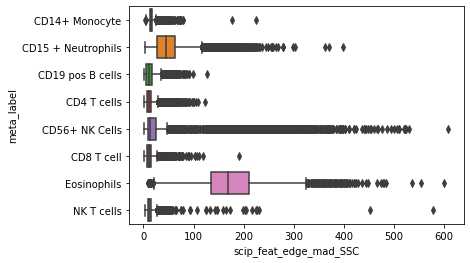

In [103]:
seaborn.boxplot(
    data=df_train,
    x=Xs.columns[s[-10:][::-1][1]],
    y="meta_label",
    hue_order=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"]
)

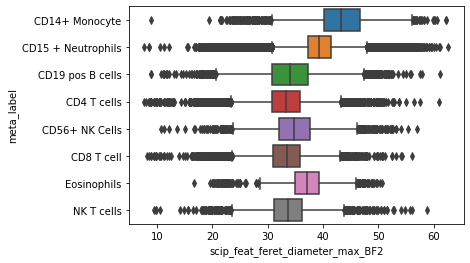

In [104]:
seaborn.boxplot(
    data=df_train,
    x=Xs.columns[s[-10:][::-1][7]],
    y="meta_label",
    hue_order=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"]
)

#### SHAP analysis to identify features explaining cell states

In [ ]:
# we only look at events that were correctly predicted by the model
Xs_correct = Xs_test[preds == y_test]

In [ ]:
numpy.random.seed(0)
explainer = shap.TreeExplainer(model)
shap_values = explainer(Xs_correct)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


To understand the SHAP algorithm, we first have to understand how a gradient boosting classifier works. In short, $N$ different decision trees are trained to predict a class from the input features. When a prediction needs to be made, each tree produces its prediction in the form of a vector containing negative and positive ones. In this setting, each output vector will contain 4 numbers (= amount of states) of which only one will be positive (= the state this decision tree thinks the input belongs to). The vectors from all the trees are then added using a weighted sum. This produces one vector containing for numbers. The class with the highest number is the one predicted by the gradient boosting model.

The SHAP algorithm then analyzes the trees in the gradient boosting model, and tries to attribute how much each feature with it's specific value contributed to the numbers that are output by the model. 

This way the SHAP analysis is similar to the feature importance above, but it gives us a much more detailed look into feature importances: for every value of every feature of every instance we get a particular importance score. 

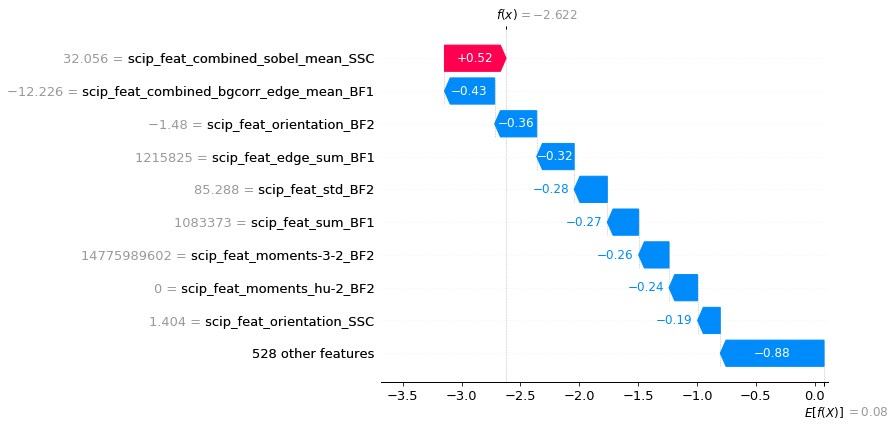

In [ ]:
shap.plots.waterfall(shap_values[0, :, enc.transform(["Eosinophils"])[0]])

##### MCP-/PSBA+ events

Above, we saw an explanation for one event. Below, we see the beeswarm plot, which summarizes the contributions of the features for all events in the dataset. This is still for the MCP-/PSBA+ class. 

Each dot on the plot corresponds to one event. The color of the dot indicates the value of the feature for an event (low to high, blue to red). The rows are ordered according to average importance over the dataset. If a dot is to the left of the center-line, the feature contributes negatively to the event being classified in the MCP-/PSBA+ state. If it is on the right, it contributes positively (= making it more likely that an event would be classified as this state).

On the first row, we again find the MAD of the edge of cell in the BF channel. We can see that on average high values of this feature contribute positively to events being classified as MCP-/PSBA+. On the second row, we find the maximum value of the sobel map of the DAPI channel. The sobel map computes the gradient of neighbouring pixels in the image. A high maximum value of the sobel map means that the image contains a set of neighbouring pixels that have a large difference in intensity. If this feature is low, the neighbouring pixels are more uniform and don't change rapidly. Because the red dots are mainly to the left of the center line, we can derive that high values of this feature contribute negatively to an event being classified as MCP-/PSBA+. Events with a more uniform DAPI signal (= blue dots to the right of the center line) are more likely to be classified as MCP-/PSBA+ cells.

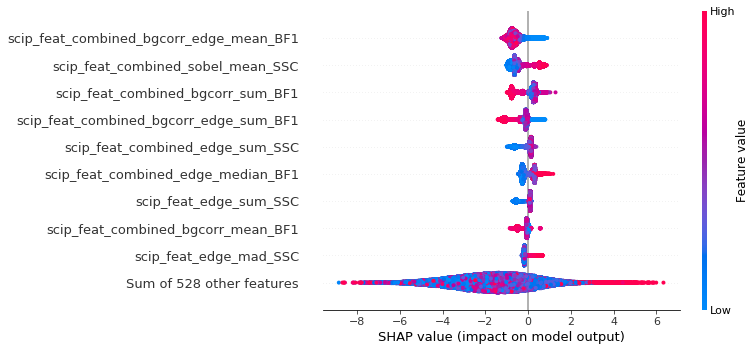

In [ ]:
label = enc.transform(["Eosinophils"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

A final new SHAP plot shown below, zooms in on one specific feature. It shows the feature's contribution to the prediction in function of the feature value. In the plot we look at the maximum sobel value in the DAPI channel. Each dot corresponds again to one event. This plot allows us to see patterns within the range of values that a feature can assume. 

On the X-axis we see the possible values of the feature in the dataset, and in gray the distribution of it. On the Y-axis, we see the contribution of the feature to the MCP-/PSBA+ state prediction. Ignoring the color of the dots for now, we can derive that as the maximum sobel value of the DAPI channel increases beyond approximately 150 the feature starts to contribute negatively to the MCP-/PSBA+ state. Events with a value less then 150 are thus more likely to be classified as MCP-/PSBA+.

A second aspect is the color. This color denotes the value of another feature, in this case kurtosis of the distribution of intensities in the DAPI channel. This feature interacts strongly with the maximum sobel value in the DAPI channel. For example, we can see that values that have a maximum sobel of less than 150 and a high kurtosis value have a smaller positive contribution towards MCP-/PSBA+ than the events with a low kurtosis value. So in biological terms this means that events with a uniform DAPI signal and a narrow distribution of DAPI intensities are more likely to be MCP-/PSBA+ events than those with a wide distribution of DAPI intensities. 

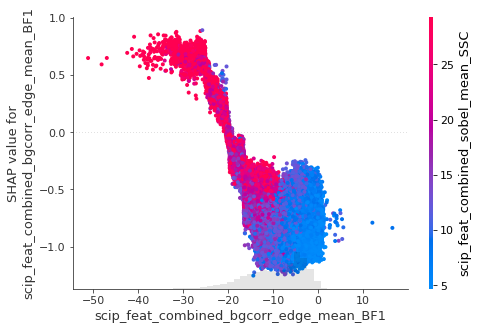

In [ ]:
label = enc.transform(["Eosinophils"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_combined_bgcorr_edge_mean_BF1", label], color=shap_values[:, :, label])

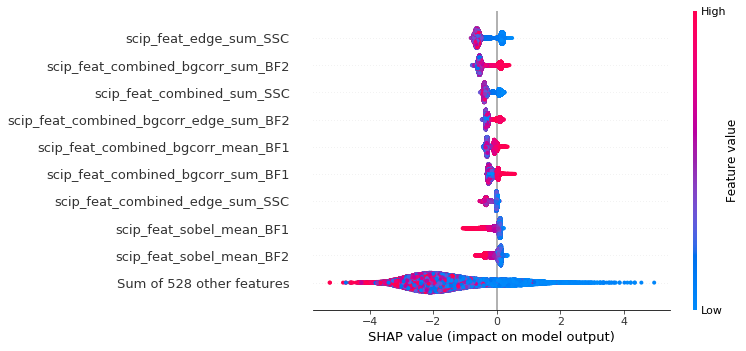

In [ ]:
label = enc.transform(["CD8 T cell"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

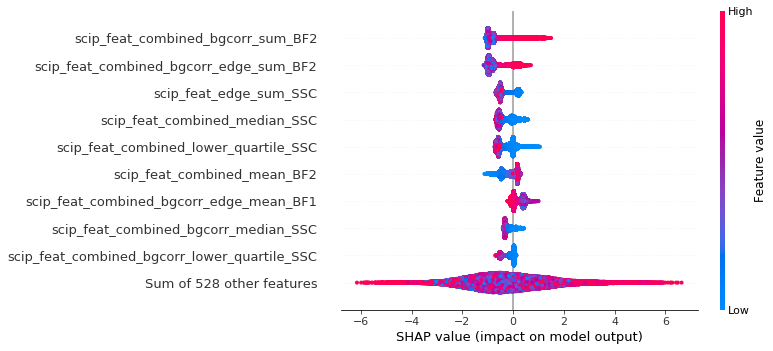

In [ ]:
label = enc.transform(["CD4 T cells"])[0]
shap.plots.beeswarm(shap_values[:, :, label])